# 머신러닝 과제 발표자료

# 주제: Shelter Animal Outcomes

In [1]:
'''Import all the necessary packages'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
import xgboost

from patsy import dmatrix
from scipy import stats

import statsmodels.api as sm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import requests
from bs4 import BeautifulSoup

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\cck3\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 인자설명 및 과제 목표

종속변수 (y): OutcomeType -> Returned to owner, Adoption, Transfer, Euthanasia, Died

독립변수 (X): AnimalID, Name, DateTime, OutcomeSubType, AnimalType, SexuponOutcome, AgeuponOutcome, Breed, Color

(추가 설명 첨부 필요)

주어진 종속변수를 사용하여 Shelter 애완동물의 Outcome을 예측하는 프로젝트. 예측 Outcome으로는 Returned to Owner, Transfer, Adoption, Euthanasia, Death가 있다.

## EDA & Feature Engineering

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

'''Keep a copy of the original data for comparison'''
data_original_train = data_train.copy()
data_original_test = data_test.copy()

### 1) NaN값 파악 + train, test 데이터 취합

In [3]:
def graph_na(data_train):
    plt.figure()
    missing_data_count = data_train.isnull().sum()
    missing_data_count.sort_values(ascending = False, inplace = True)
    missing_data_count_filtered = missing_data_count[missing_data_count > 0]
    missing_data_count_filtered.plot(kind = 'bar', title = 'missing data count')
    plt.show()

In [4]:
data_train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [5]:
data_test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

In [6]:
#Train과 Test를 합쳐서 한번에 전처리 진행
#OutcomeSubtype은 Train에만 있는 데이터기 때문에 Drop
dfY = data_train['OutcomeType']
data_train_drop = data_train.drop('OutcomeSubtype', axis = 1)
data_train_drop.drop('OutcomeType', axis = 1, inplace = True)

data_test = data_test.rename(columns = {'ID':'AnimalID'})
data_combined = pd.concat([data_train_drop, data_test], axis = 0)

In [7]:
dfY.shape

(26729,)

In [8]:
data_combined.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [9]:
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11451,11452,NaN,2014-07-08 14:50,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black
11452,11453,NaN,2014-10-21 12:57,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue
11453,11454,NaN,2014-09-29 9:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [10]:
data_combined.isnull().sum()

AnimalID              0
Name              10916
DateTime              0
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       24
Breed                 0
Color                 0
dtype: int64

### 1.2) Name -> 이름이 있을경우 'Name'으로 없을경우 No Name'으로 변환

In [11]:
def no_name_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    if type(x) == float:
        return 'No Name'
    else:
        return 'Name'

In [12]:
data_combined['Name'] = data_combined['Name'].transform(no_name_label)

### 2) 날짜 데이터 분류 -> 날짜 데이터에서 년, 월, 일, 시간 자료 추출 및 계절 변수 형성

In [13]:
def datetime_str_converter(data_train):
    '''This method converts the datetime input into year and month in
    string format. The below method is identical except it returns numerical
    value. The string format is used for graphing with countplot'''
    datetime = list(data_train['DateTime'])
    year_list, month_list, day_list, hour_list = [], [], [], []
    for item in datetime:
        year_list.append(item[:4])
        month_list.append(item[5:7])
        day_list.append(item[8:10])
        hour_list.append(item[11:13])
    return year_list, month_list, day_list, hour_list

def season_sort(month_list):
    '''Converts month information to season information'''
    season_list = []
    for item in month_list:
        item = int(item)
        if item == 12 or item == 1 or item == 2:
            season_list.append('winter')
        elif item >=3 and item <=5:
            season_list.append('spring')
        elif item >= 6 and item <= 8:
            season_list.append('summer')
        elif item >= 9 and item <= 11:
            season_list.append('fall')
    return season_list

In [14]:
'''Year and Month information extraction'''
year_list, month_list, day_list, hour_list = datetime_str_converter(data_combined)
date_list = []
for year, month in zip(year_list, month_list):
    date_list.append(int(year + month))

#Data를 년, 월, 일, 시간 그리고 년 + 월 합친 데이터로 변환
data_combined['Date'] = date_list
data_combined['OutcomeYear'], data_combined['OutcomeMonth'] = year_list, month_list
data_combined['OutcomeDay'], data_combined['OutcomeHour'] = day_list, hour_list

#계절 데이터 형성
season_list = season_sort(month_list)
data_combined['OutcomeSeason'] = season_list

In [15]:
#Data 확인
data_combined.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
0,A671945,Name,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,201402,2014,02,12,18,winter
1,A656520,Name,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,201310,2013,10,13,12,fall
2,A686464,Name,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,201501,2015,01,31,12,winter
3,A683430,No Name,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,201407,2014,07,11,19,summer
4,A667013,No Name,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,201311,2013,11,15,12,fall


In [16]:
#Data 확인
data_combined.tail()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
11451,11452,No Name,2014-07-08 14:50,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer
11452,11453,No Name,2014-10-21 12:57,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall
11453,11454,No Name,2014-09-29 9:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall
11454,11455,Name,2015-09-05 17:16,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall
11455,11456,Name,2014-07-12 18:40,Dog,Intact Male,4 years,Labrador Retriever,Cream,201407,2014,07,12,18,summer


### 3) 동물 Size및 선호도 Crawling 

개종을 Size로 변환. Breed의 Unique값 분석결과 1200종이 넘는것으로 확인됨. 이러한 data를 그래로 사용할 경우 Overfitting등의 문제가 있기 때문에 2가지 방법으로 접근할 예전
  
1) 순종 Breed에 관해서는 Size로 변환 -> 잡종일 경우 유전적 factor에 의해서 크기 예측이 쉽지 않음. 이 작업을 수작업으로 하기에는 너무 많은 시간이 소요가 되기 때문에 방법 탐색중 순종을 크기 별로 나눠놓은 웹사이트 발견 -> Crawling

Mixed Breed Reference: http://www.vetstreet.com/our-pet-experts/can-you-predict-the-adult-size-of-a-mixed-breed-puppy

Size Reference : http://www.dogbreedslist.info/herding-dog-breeds/#.WgfCyMZl-iN


2) 다른 Kaggle 참가자에 따르면 애완견의 선호도 랭킹또한 예측 모델에 큰 영향을 준다는 정보 입수

Ranking Reference: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

개는 2016년 기준으로 랭킹이 매겨져 있으며 고양이는 2014년 기준으로 랭킹이 존재함. 위 첨부자료에서는 2013, 2014, 2015년별 랭킹변화를 모두 인자로 채택했지만, 자세히 보면 랭킹에 큰 변동이 없는것으로 확인되었기 때문에 굳이 매년 선호도 점수를 쓸 필요성은 없는것으로 판단됨.

In [17]:
def crawler(url, selector):
    '''This is one of the two functions used for crawlign cat/dog size'''
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    crawl_list = soup.select(selector)
    compile_list = []
    for breed in crawl_list:
        compile_list.append(breed.get_text().lower())
    return compile_list

def crawl_compiler(url_list, selector):
    '''This is the second functions used for crawlign cat/dog size'''
    list_compile = []
    for url in url_list:
        crawler_list = crawler(url, selector)
        list_compile += crawler_list
    return list_compile

In [18]:
'''This section is for crawling the dog size list'''

'''Extract list of dogs for different sizes'''
small_url_list = ['http://www.dogbreedslist.info/small-dog-breeds/list_2_1.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_2.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_3.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_4.html#.Wfx1Mmi0NPY', 
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_5.html#.Wfx1Mmi0NPY',
                'http://www.dogbreedslist.info/small-dog-breeds/list_2_6.html#.Wfx1Mmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
small_dog_compile = crawl_compiler(small_url_list, selector)

medium_url_list = ['http://www.dogbreedslist.info/medium-dog-breeds/list_3_1.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_2.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_3.html#.Wfx3bmi0NPY', 
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_4.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_5.html#.Wfx3bmi0NPY',
                   'http://www.dogbreedslist.info/medium-dog-breeds/list_3_6.html#.Wfx3bmi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
medium_dog_compile = crawl_compiler(medium_url_list, selector) + ['treeing cur', 'treeing tennesse brindle']

large_url_list = ['http://www.dogbreedslist.info/large-dog-breeds/list_4_1.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_2.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_3.html#.Wfx9nWi0NPY', 
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_4.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_5.html#.Wfx9nWi0NPY',
                   'http://www.dogbreedslist.info/large-dog-breeds/list_4_6.html#.Wfx9nWi0NPY']

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
large_dog_compile = crawl_compiler(large_url_list, selector) + ['schnauzer giant', 'olde english bulldogge']

giant_url_list = ['http://www.dogbreedslist.info/giant-dog-breeds/list_5_1.html#.Wfx9nWi0NPY',]

selector = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
giant_dog_compile = crawl_compiler(giant_url_list, selector)

In [19]:
print(medium_dog_compile)

['labrador retriever', 'bulldog', 'poodle', 'boxer', 'siberian husky', 'australian shepherd', 'brittany', 'english springer spaniel', 'american cocker spaniel', 'vizsla', 'weimaraner', 'miniature american shepherd', 'border collie', 'basset hound', 'shiba inu', 'belgian malinois', 'soft coated wheaten terrier', 'portuguese water dog', 'australian cattle dog', 'airedale terrier', 'english cocker spaniel', 'bull terrier', 'whippet', 'shar-pei', 'german wirehaired pointer', 'samoyed', 'wirehaired pointing griffon', 'chow chow', 'american staffordshire terrier', 'staffordshire bull terrier', 'standard schnauzer', 'nova scotia duck tolling retriever', 'basenji', 'tibetan terrier', 'norwegian elkhound', 'wire fox terrier', 'belgian tervuren', 'boykin spaniel', 'lagotto romagnolo', 'pointer', 'american eskimo dog', 'welsh springer spaniel', 'bearded collie', 'kerry blue terrier', 'treeing walker coonhound', 'berger picard', 'redbone coonhound', 'clumber spaniel', 'german pinscher', 'field spa

In [20]:
'''This portion is for crawling the favorite ranking of dogs'''

ranking_url_list = []
for i in range(1, 11):
    url = 'http://www.dogbreedslist.info/all-dog-breeds/list_1_' + str(i) + '.html#.WhE_9kpl-iM'
    ranking_url_list.append(url)
    
selector_breed = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
selector_rank = 'body > div.main > div.main-r > div > div.list-02 > p'

breed_compile_dog = crawl_compiler(ranking_url_list, selector_breed)
rank_compile_dog = crawl_compiler(ranking_url_list, selector_rank)

In [22]:
breed_compile_dog = breed_compile_dog[:188]
rank_compile_dog = rank_compile_dog[:188]

In [23]:
print(len(breed_compile_dog))
print(breed_compile_dog)

188
['labrador retriever', 'german shepherd', 'golden retriever', 'bulldog', 'beagle', 'french bulldog', 'poodle', 'rottweiler', 'yorkshire terrier', 'boxer', 'german shorthaired pointer', 'siberian husky', 'dachshund', 'great dane', 'doberman pinscher', 'australian shepherd', 'miniature schnauzer', 'pembroke welsh corgi', 'cavalier king charles spaniel', 'shih tzu', 'boston terrier', 'pomeranian', 'havanese', 'shetland sheepdog', 'brittany', 'english springer spaniel', 'bernese mountain dog', 'mastiff', 'american cocker spaniel', 'chihuahua', 'vizsla', 'pug', 'maltese', 'weimaraner', 'newfoundland', 'miniature american shepherd', 'collie', 'border collie', 'basset hound', 'cane corso', 'west highland white terrier', 'rhodesian ridgeback', 'chesapeake bay retriever', 'shiba inu', 'bichon frise', 'akita', 'belgian malinois', 'bullmastiff', 'st. bernard', 'soft coated wheaten terrier', 'portuguese water dog', 'bloodhound', 'papillon', 'australian cattle dog', 'airedale terrier', 'english

In [24]:
print(len(rank_compile_dog))
print(rank_compile_dog)

188
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '63', '64', '65', '66', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158

In [99]:
rank_compile_dog_numeric = []
for item in rank_compile_dog:
    rank_compile_dog_numeric.append(int(item))
rank_compile_dog_numeric

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 186

In [102]:
rank_dict_dog = {}
for breed, rank in zip(breed_compile_dog, rank_compile_dog_numeric):
    rank_dict_dog[breed] = rank
print(rank_dict_dog)

{'labrador retriever': 1, 'german shepherd': 2, 'golden retriever': 3, 'bulldog': 4, 'beagle': 5, 'french bulldog': 6, 'poodle': 7, 'rottweiler': 8, 'yorkshire terrier': 9, 'boxer': 10, 'german shorthaired pointer': 11, 'siberian husky': 12, 'dachshund': 13, 'great dane': 14, 'doberman pinscher': 15, 'australian shepherd': 16, 'miniature schnauzer': 17, 'pembroke welsh corgi': 18, 'cavalier king charles spaniel': 19, 'shih tzu': 20, 'boston terrier': 21, 'pomeranian': 22, 'havanese': 23, 'shetland sheepdog': 24, 'brittany': 25, 'english springer spaniel': 26, 'bernese mountain dog': 27, 'mastiff': 28, 'american cocker spaniel': 29, 'chihuahua': 30, 'vizsla': 31, 'pug': 32, 'maltese': 33, 'weimaraner': 34, 'newfoundland': 35, 'miniature american shepherd': 36, 'collie': 37, 'border collie': 38, 'basset hound': 39, 'cane corso': 40, 'west highland white terrier': 41, 'rhodesian ridgeback': 42, 'chesapeake bay retriever': 43, 'shiba inu': 44, 'bichon frise': 45, 'akita': 46, 'belgian mali

In [25]:
'''This portion is for crawling the 2014 ranking of cats'''

ranking_url_list_cat = []
for i in range(1, 4):
    url = 'http://www.catbreedslist.com/all-cat-breeds/list_1_' + str(i) + '.html#.WhGa1Upl-iM'
    ranking_url_list_cat.append(url)
    
selector_breed_cat = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-t > p > a'
selector_rank_cat = 'body > div.main > div.main-r > div > div.list-01 > div.right > div.right-c > div.pop > p'

breed_compile_cat = crawl_compiler(ranking_url_list_cat, selector_breed_cat)
rank_compile_cat = crawl_compiler(ranking_url_list_cat, selector_rank_cat)

In [26]:
breed_compile_cat = breed_compile_cat[:41]
rank_compile_cat = rank_compile_cat[:41]

In [27]:
print(len(breed_compile_cat))
print(breed_compile_cat)

41
['exotic shorthair', 'persian', 'maine coon', 'ragdoll', 'british shorthair', 'american shorthair', 'abyssinian', 'sphynx', 'siamese', 'scottish fold', 'cornish rex', 'devon rex', 'oriental', 'norwegian forest cat', 'birman', 'burmese', 'siberian', 'tonkinese', 'russian blue', 'egyptian mau', 'ocicat', 'singapura', 'manx', 'japanese bobtail', 'selkirk rex', 'american curl', 'chartreux', 'somali', 'turkish angora', 'colorpoint shorthair', 'balinese', 'ragamuffin', 'european burmese', 'bombay', 'havana brown', 'american bobtail', 'turkish van', 'burmilla', 'laperm', 'korat', 'american wirehair']


In [28]:
print(len(rank_compile_cat))
print(rank_compile_cat)

41
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


In [81]:
rank_dict_cat = {}
for breed, rank in zip(breed_compile_cat, rank_compile_cat):
    rank_dict_cat[breed] = rank
print(rank_dict_cat)

{'exotic shorthair': '1', 'persian': '2', 'maine coon': '3', 'ragdoll': '4', 'british shorthair': '5', 'american shorthair': '6', 'abyssinian': '7', 'sphynx': '8', 'siamese': '9', 'scottish fold': '10', 'cornish rex': '11', 'devon rex': '12', 'oriental': '13', 'norwegian forest cat': '14', 'birman': '15', 'burmese': '16', 'siberian': '17', 'tonkinese': '18', 'russian blue': '19', 'egyptian mau': '20', 'ocicat': '21', 'singapura': '22', 'manx': '23', 'japanese bobtail': '24', 'selkirk rex': '25', 'american curl': '26', 'chartreux': '27', 'somali': '28', 'turkish angora': '29', 'colorpoint shorthair': '30', 'balinese': '31', 'ragamuffin': '32', 'european burmese': '33', 'bombay': '34', 'havana brown': '35', 'american bobtail': '36', 'turkish van': '37', 'burmilla': '38', 'laperm': '39', 'korat': '40', 'american wirehair': '41'}


### 6) 필요없는 feature 제거

In [29]:
data_combined.drop('DateTime', axis = 1, inplace = True)

In [30]:
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
11451,11452,No Name,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer
11452,11453,No Name,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall
11453,11454,No Name,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall
11454,11455,Name,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall
11455,11456,Name,Dog,Intact Male,4 years,Labrador Retriever,Cream,201407,2014,07,12,18,summer


### 7) OutcomeType 심층분석

In [31]:
def count_outcome(dfY):
    plt.figure()
    outcome = dfY.value_counts()
    outcome.plot(kind = 'bar', title = 'Outcome variable count')
    plt.show()

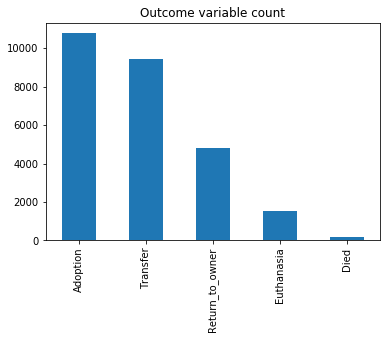

In [32]:
count_outcome(dfY)

### 8) AgeUponOutcome 데이터를 모두 일(day) 단위로 변환

#### Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string

In [33]:
'''This section of the code is used to check the unique string values that are present in the AgeuponOutcome column'''
age_list_compile = []
age_outcome_list = list(data_combined['AgeuponOutcome'])
for item in age_outcome_list:
    if type(item) != str:
        '''This condition is to account for NaN values'''
        continue
    result = ''.join(i for i in item if not i.isdigit())
    age_list_compile.append(result)
'''We can check unique string values in the column'''
age_list_unique = list(pd.Series(age_list_compile).unique())
print(age_list_unique)
'''This list contains year(s), month(s), week(s), day(s)'''

[' year', ' years', ' weeks', ' month', ' months', ' days', ' week', ' day']


'This list contains year(s), month(s), week(s), day(s)'

#### age_list_unique 리스트 확인결과 year, years, month, months, week, weeks, day, days의 유니크한 값을 가짐. 나이관련 변수 단위를 일(day)로 통일

In [34]:
def convert_Age(data_train):
    '''Reference: https://stackoverflow.com/questions/12851791/removing-numbers-from-string'''
    '''This function convert all the time into unit of day'''
    age_list = list(data_train['AgeuponOutcome'])
    age_day_compile = []
    for item in age_list:
        if type(item) != str:
            age_day_compile.append(item)
        else:
            numeric = int(item[:2])
            if 'year' in item:
                age_day_compile.append(numeric * 365)
            elif 'month' in item:
                age_day_compile.append(numeric * 30)
            elif 'week' in item:
                age_day_compile.append(numeric * 7)
            elif 'day' in item:
                age_day_compile.append(numeric)
    return age_day_compile 

In [35]:
age_day_compile = convert_Age(data_combined)
data_combined['AgeuponOutcome'] = age_day_compile

In [36]:
#Data 확인
data_combined.head()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
0,A671945,Name,Dog,Neutered Male,365.0,Shetland Sheepdog Mix,Brown/White,201402,2014,02,12,18,winter
1,A656520,Name,Cat,Spayed Female,365.0,Domestic Shorthair Mix,Cream Tabby,201310,2013,10,13,12,fall
2,A686464,Name,Dog,Neutered Male,730.0,Pit Bull Mix,Blue/White,201501,2015,01,31,12,winter
3,A683430,No Name,Cat,Intact Male,21.0,Domestic Shorthair Mix,Blue Cream,201407,2014,07,11,19,summer
4,A667013,No Name,Dog,Neutered Male,730.0,Lhasa Apso/Miniature Poodle,Tan,201311,2013,11,15,12,fall


In [37]:
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
11451,11452,No Name,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer
11452,11453,No Name,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall
11453,11454,No Name,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall
11454,11455,Name,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall
11455,11456,Name,Dog,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer


### 9) 애완견 종을 순종, 순종 mix, 잡종으로 나눠서 분석

In [38]:
def dog_breed_category(data_train):
    '''This function converts the breed into pure mix, mix or pure'''
    breed_df = data_train[['OutcomeType', 'AnimalType', 'Breed']]
    breed_df_dog = breed_df[breed_df.AnimalType == 'Dog'].reset_index()
    breed_list = list(breed_df_dog['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            breed_compile.append('pure mix')
        elif '/' in item:
            breed_compile.append('mix')
        else:
            breed_compile.append('pure')
    breed_df_dog['Breed_dog'] = breed_compile
    return breed_df_dog

In [39]:
breed_df_dog = dog_breed_category(data_train)

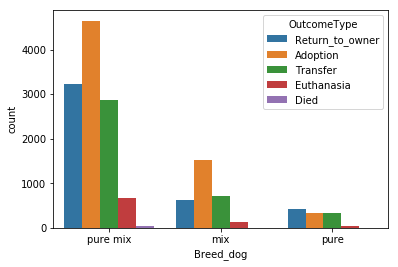

In [40]:
#순종/잡종 개와 OutcomeType 관계 그래프
sns.countplot(x = 'Breed_dog', hue = 'OutcomeType', data = breed_df_dog)
plt.show()

#### 순종견 (Pure)는 갯수가 많지 않기 때문에 순종 mix와 순종은 같은 종으로 고려함 (타 Kaggle 분석에서도 이런식으로 진행한것 확인)

In [41]:
def remove_mix(data_train):
    '''This function removes the keyword mix from breed list. The result from
    this method is used when converting breed into different categories'''
    breed_list = list(data_train['Breed'])
    breed_compile = []
    for item in breed_list:
        item = item.lower()
        if 'mix' in item:
            item = item[:-4]
        breed_compile.append(item)
    return breed_compile

In [42]:
breed_remove_mix = remove_mix(data_combined)

### 10) Data Visualization

Data Visualization 부분은 결과값과 인자관의 상관간계를 나타내는 데이터가 필요하기 때문에 전처리 작업을 하고있는 data_combined가 아닌 data_train을 이용하여 작업진행

In [43]:
data_temp = pd.concat([data_combined.iloc[:26729, :], dfY], axis = 1)

In [44]:
data_temp.head()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,OutcomeType
0,A671945,Name,Dog,Neutered Male,365.0,Shetland Sheepdog Mix,Brown/White,201402,2014,02,12,18,winter,Return_to_owner
1,A656520,Name,Cat,Spayed Female,365.0,Domestic Shorthair Mix,Cream Tabby,201310,2013,10,13,12,fall,Euthanasia
2,A686464,Name,Dog,Neutered Male,730.0,Pit Bull Mix,Blue/White,201501,2015,01,31,12,winter,Adoption
3,A683430,No Name,Cat,Intact Male,21.0,Domestic Shorthair Mix,Blue Cream,201407,2014,07,11,19,summer,Transfer
4,A667013,No Name,Dog,Neutered Male,730.0,Lhasa Apso/Miniature Poodle,Tan,201311,2013,11,15,12,fall,Transfer


In [45]:
data_temp.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,OutcomeType
26724,A702446,No Name,Cat,Intact Male,30.0,Domestic Shorthair Mix,Brown Tabby/White,201505,2015,05,14,11,spring,Transfer
26725,A718934,No Name,Cat,Spayed Female,90.0,Domestic Shorthair Mix,Brown Tabby,201601,2016,01,20,18,winter,Transfer
26726,A698128,Name,Dog,Neutered Male,1460.0,Old English Bulldog Mix,White/Tan,201503,2015,03,09,13,spring,Adoption
26727,A677478,No Name,Cat,Intact Male,28.0,Domestic Shorthair Mix,Black,201404,2014,04,27,12,spring,Transfer
26728,A706629,No Name,Cat,Intact Male,365.0,Domestic Shorthair Mix,Brown Tabby/White,201507,2015,07,02,09,summer,Transfer


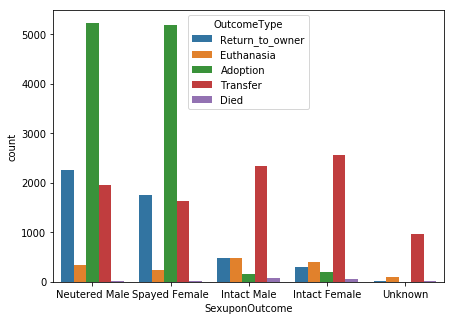

In [46]:
%matplotlib inline
#SexuponOutcome과 결과값 관게 그래프
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(ax = ax, x = 'SexuponOutcome', hue = 'OutcomeType', data = data_temp)
plt.show()

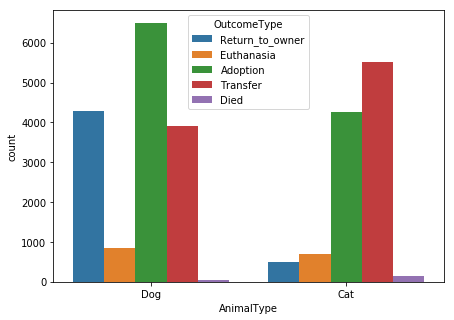

In [47]:
#AnimalType (개 or 고양이)과 결과값 관계 그래프 
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x = 'AnimalType', hue = 'OutcomeType', data = data_temp)
plt.show()

#### Reference: https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot

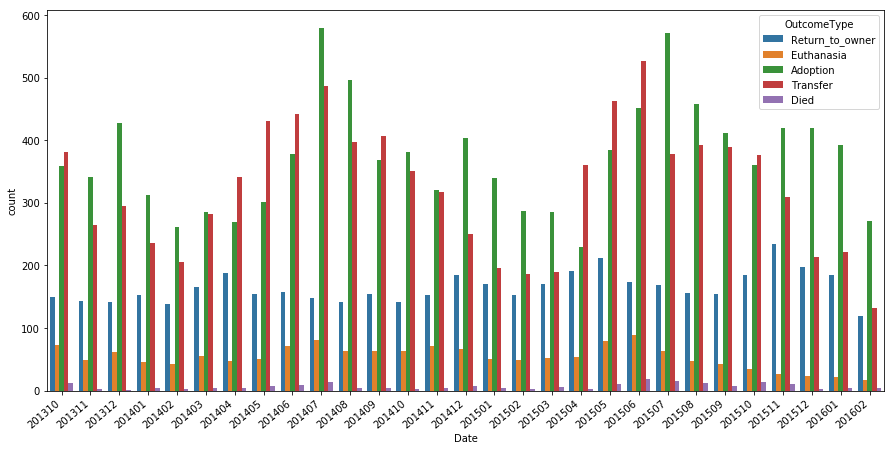

In [48]:
#날짜와 결과값 관계 그래프
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(x = 'Date', hue = 'OutcomeType', data = data_temp)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

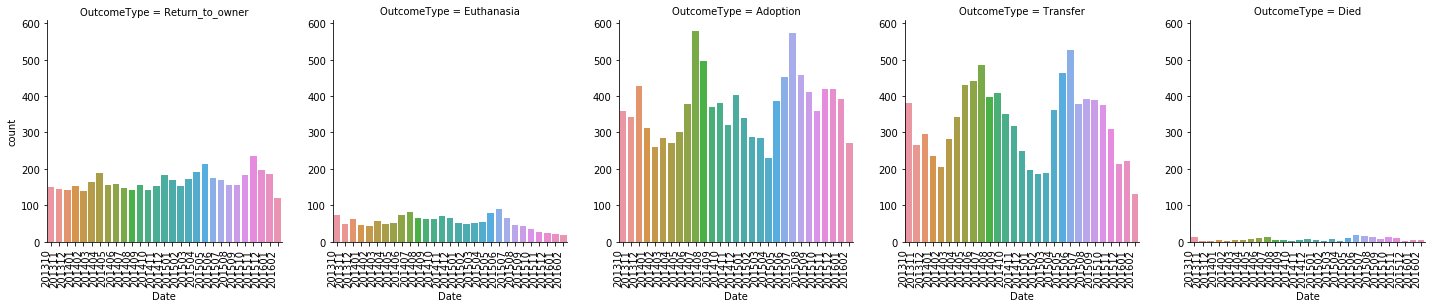

In [49]:
plt.figure(figsize=(20,20))
ax2 = sns.factorplot(x = 'Date', col = 'OutcomeType', data = data_temp, kind = 'count')
ax2.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

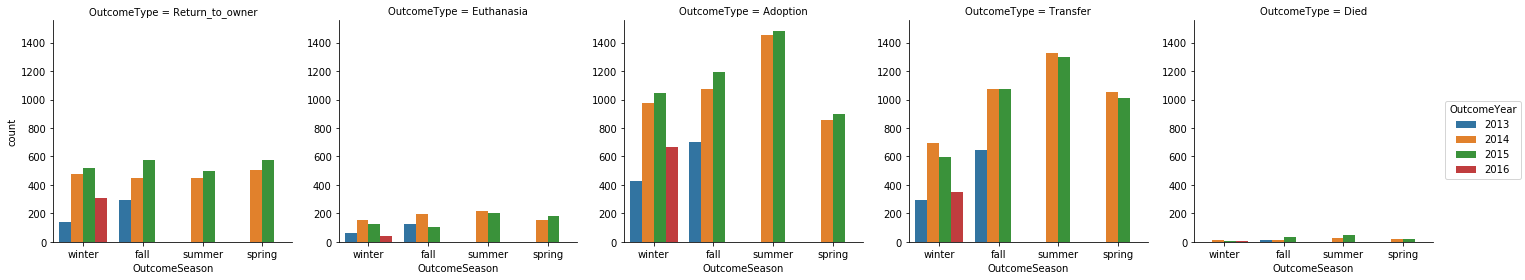

In [50]:
#계절별 OutcomeType 관계 그래프
sns.factorplot(x = 'OutcomeSeason', hue = 'OutcomeYear', col = 'OutcomeType', data = data_temp, kind = 'count')
plt.show()

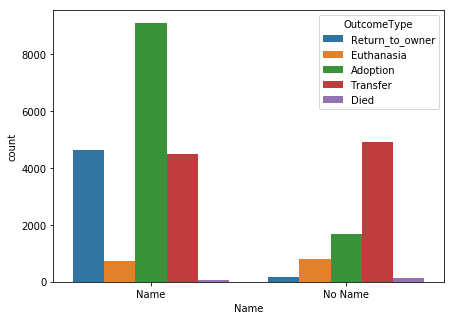

In [51]:
#이름 유/무와 OutcomeType 관계 그래프
plt.figure(figsize = (7, 5))
sns.countplot(x = 'Name', hue = 'OutcomeType', data = data_temp)
plt.show()

### Name인자 숫자 Preprocessing

#### Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb

In [52]:
def no_name_numeric_label(x):
    '''Reference: https://github.com/JihongL/Shelter-Animal-Outcomes/blob/master/Shelter_EDA.ipynb'''
    '''This function is used in conjunction with .transform() method to convert Name and No Name 
    to numerical values'''
    if x == 'No Name':
        return 0
    else:
        return 1

In [53]:
data_combined['Name'] = data_combined['Name'].transform(no_name_numeric_label)

In [54]:
data_combined.head()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
0,A671945,1,Dog,Neutered Male,365.0,Shetland Sheepdog Mix,Brown/White,201402,2014,02,12,18,winter
1,A656520,1,Cat,Spayed Female,365.0,Domestic Shorthair Mix,Cream Tabby,201310,2013,10,13,12,fall
2,A686464,1,Dog,Neutered Male,730.0,Pit Bull Mix,Blue/White,201501,2015,01,31,12,winter
3,A683430,0,Cat,Intact Male,21.0,Domestic Shorthair Mix,Blue Cream,201407,2014,07,11,19,summer
4,A667013,0,Dog,Neutered Male,730.0,Lhasa Apso/Miniature Poodle,Tan,201311,2013,11,15,12,fall


In [55]:
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
11451,11452,0,Cat,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer
11452,11453,0,Cat,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall
11453,11454,0,Cat,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall
11454,11455,1,Dog,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall
11455,11456,1,Dog,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer


### AnimalType mapping -> 개는 1, 고양이는 0으로 dummy variable 생성

In [56]:
animal_type_mapping = {'Dog':1, 'Cat':0}
data_combined['AnimalType'] = data_combined['AnimalType'].map(animal_type_mapping)

### 결과값 'OutcomeType' 전처리 -> Animal mapping과 동일한 방법으로 .map()함수를 이용하여 전처리 진행

In [57]:
outcome_mapping = {'Return_to_owner':1, 'Euthanasia':2, 'Adoption':3, 'Transfer':4, 'Died':5}
dfY = dfY.map(outcome_mapping)

In [58]:
print(dfY)

0        1
1        2
2        3
3        4
4        4
5        4
6        4
7        4
8        3
9        3
10       4
11       3
12       3
13       1
14       1
15       3
16       4
17       4
18       4
19       1
20       4
21       4
22       3
23       3
24       1
25       4
26       3
27       3
28       3
29       1
        ..
26699    2
26700    1
26701    4
26702    5
26703    4
26704    4
26705    4
26706    3
26707    2
26708    4
26709    3
26710    4
26711    4
26712    1
26713    2
26714    3
26715    3
26716    3
26717    1
26718    3
26719    4
26720    3
26721    3
26722    4
26723    3
26724    4
26725    4
26726    3
26727    4
26728    4
Name: OutcomeType, Length: 26729, dtype: int64


### 11) 모든 견종이 Crawling한 list에 존재하나 줄임말 또는 표기법이 달라서 인식이 안되는 종이 30종 정도 있는것으로 확인하였음 . 종이 그렇게 많지 않기 때문에 노가다 작업진행

In [59]:
for index, item in enumerate(breed_remove_mix):
    if item == 'chihuahua shorthair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'collie smooth':
        breed_remove_mix[index] = 'collie'
    elif item == 'anatol shepherd':
        breed_remove_mix[index] = 'anatolian shepherd dog'
    elif item == 'port water dog':
        breed_remove_mix[index] = 'portuguese water dog'
    elif item == 'flat coat retriever':
        breed_remove_mix[index] = 'flat-coated retriever'
    elif item == 'pbgv':
        breed_remove_mix[index] = 'petit basset griffon vendeen'
    elif item == 'bruss griffon':
        breed_remove_mix[index] = 'brussels griffon'
    elif item == 'bluetick hound':
        breed_remove_mix[index] = 'bluetick coonhound'
    elif item == 'wire hair fox terrier':
        breed_remove_mix[index] = 'wire fox terrier'
    elif item == 'dachshund wirehair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'rhod ridgeback':
        breed_remove_mix[index] = 'rhodesian ridgeback'
    elif item == 'picardy sheepdog':
        breed_remove_mix[index] = 'berger picard'
    elif item == 'st. bernard rough coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item == 'old english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'english bulldog':
        breed_remove_mix[index] = 'olde english bulldogge'
    elif item == 'chesa bay retr':
        breed_remove_mix[index] = 'chesapeake bay retriever'
    elif item == 'dachshund longhair':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'chihuahua longhair':
        breed_remove_mix[index] = 'chihuahua'
    elif item == 'chinese sharpei':
        breed_remove_mix[index] = 'shar-pei'
    elif item == 'standard poodle':
        breed_remove_mix[index] = 'poodle'
    elif item == 'bull terrier miniature':
        breed_remove_mix[index] = 'miniature bull terrier'
    elif item =='st. bernard smooth coat':
        breed_remove_mix[index] = 'st. bernard'
    elif item =='redbone hound':
        breed_remove_mix[index] = 'redbone coonhound'
    elif item == 'cavalier span':
        breed_remove_mix[index] = 'cavalier king charles spaniel'
    elif item == 'collie rough':
        breed_remove_mix[index] = 'collie'
    elif item == 'german shorthair pointer':
        breed_remove_mix[index] = 'german shorthaired pointer'
    elif item == 'english pointer':
        breed_remove_mix[index] = 'pointer'
    elif item == 'mexican hairless':
        breed_remove_mix[index] = 'xoloitzcuintli'
    elif item =='dogo argentino':
        breed_remove_mix[index] = 'argentine dogo'
    elif item == 'queensland heeler':
        breed_remove_mix[index] = 'australian cattle dog'
    elif item == 'dachshund stan':
        breed_remove_mix[index] = 'dachshund'
    elif item == 'eng toy spaniel':
        breed_remove_mix[index] = 'english toy spaniel'

In [60]:
len(breed_remove_mix)

38185

### 12) 고양이 사이즈 -> 종류가 강아지 만큼 다양하지 않기 때문에 수작업 전처리 진행

#### Reference: http://www.petguide.com/breeds/cat/domestic-longhair/

In [61]:
small_cat_list = ['munchkin longhair', 'oriental sh']
medium_cat_list = ['exotic shorthair', 'persian', 'abyssinian', 'sphynx', 'siamese',
                   'cornish rex', 'devon rex', 'burmese', 'tonkinese', 'russian blue', 
                   'manx', 'japanese bobtail', 'balinese', 'bombay', 'havana brown',
                   'bengal', 'cymric', 'himalayan', 'snowshoe', 'javanese', 'havana brown', 'angora', 'turkish angora', 
                   'munchkin shorthair', 'scottish fold']
large_cat_list = ['american shorthair', 'british shorthair', 'norwegian forest cat', 'ocicat',
                  'turkish van', 'pixiebob shorthair', 'maine coon', 'ragdoll', 'american wirehair', 'chartreux']
domestic = ['domestic longhair', 'domestic medium hair', 'domestic shorthair']

고양이종에 domestic이 붙은 종은 북미지역에 서식하는 잡종 고양이를 뜻함. train 데이터에서도 압도적으로 많은 고양이들이 domestic 종이고 실제로도 북미지역 애완 고양이는 높은 비율로 domestic 잡종인것을 아래 참조 자료를 통해 확인하였음. 잡종인 만큼 size를 예측하기 힘들기 때문에 domestic이라는 카테고리를 따로 형성함. 내용은 아래 Reference 참고.

### 13) 개/고양이 Size 인자형성

#### Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings

In [62]:
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason
11451,11452,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer
11452,11453,0,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall
11453,11454,0,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall
11454,11455,1,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall
11455,11456,1,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer


In [63]:
def convert_breed(type_list, breed_list, small_list, medium_list, large_list, giant_list,
                  small_cat_list, medium_cat_list, large_cat_list, domestic_cat_list):
    '''Reference: https://stackoverflow.com/questions/16380326/check-if-substring-is-in-a-list-of-strings
    that is a really smart and succinct solution for checking substring existence in a list of strings'''
    
    '''The incoming list a list of breeds with the keyword "mix" removed and converted
    to lower case. No need for extra preprocessing. Also the dog lists are all converted
    to lower case as well. Type list is to check whether the breed belongs to dog or cat'''
    if len(type_list) != len(breed_list):
        print('Two lists must have equal length!')
        return None
    
    '''Convert the list into a string format for easier processing'''
    small_combined = '\t'.join(small_list)
    medium_combined = '\t'.join(medium_list)
    large_combined = '\t'.join(large_list)
    giant_combined = '\t'.join(giant_list)
    
    breed_compile, excluded_list, mix_breed_list, cat_breed_list = [], [], [], []
    for animal_type, breed in zip(type_list, breed_list):
        if '/' in breed: #Mixed type categorization
            mix_breed_list.append(breed)
            breed_compile.append('mix')
        elif animal_type == 0: #Cat breed categorization
            cat_breed_list.append(breed)
            if breed in small_cat_list:
                breed_compile.append('small_cat')
            elif breed in medium_cat_list:
                breed_compile.append('medium_cat')
            elif breed in large_cat_list:
                breed_compile.append('large_cat')
            elif breed in domestic_cat_list:
                breed_compile.append('domestic')
            else:
                excluded_list.append(breed)
        elif animal_type == 1: #Dog breed categorization
            if breed in small_combined:
                breed_compile.append('small')
            elif breed in medium_combined:
                breed_compile.append('medium')
            elif breed in large_combined:
                breed_compile.append('large')
            elif breed in giant_combined:
                breed_compile.append('giant')
            else:
                excluded_list.append(breed)
                breed_compile.append('unknown')
    return breed_compile, excluded_list, mix_breed_list, cat_breed_list

In [64]:
'''Compare the breed in the data to crawled size lists and create a list indicating
the size of each breed. By zipping two lists, we can also ignore species that
belong to cats. Some breed names were manually modified to fit the crawled list'''
type_list = list(data_combined['AnimalType'])

convert_list, excluded_list_dog, mix_breed_list_dog, cat_breed_list = convert_breed(type_list, 
                                     breed_remove_mix, small_dog_compile, 
                                     medium_dog_compile, large_dog_compile, giant_dog_compile,
                                     small_cat_list, medium_cat_list, large_cat_list, domestic)

'''With the manual correction to dog breed, this list should only contain unknown values'''
excluded_unique_dog = list(set(excluded_list_dog))
print(excluded_unique_dog)

['unknown']


In [65]:
print(set(cat_breed_list))

{'exotic shorthair', 'scottish fold', 'chartreux', 'sphynx', 'american shorthair', 'balinese', 'tonkinese', 'burmese', 'ocicat', 'abyssinian', 'munchkin longhair', 'snowshoe', 'domestic medium hair', 'american wirehair', 'british shorthair', 'oriental sh', 'munchkin shorthair', 'manx', 'turkish van', 'norwegian forest cat', 'domestic shorthair', 'angora', 'bengal', 'himalayan', 'ragdoll', 'cornish rex', 'bombay', 'persian', 'japanese bobtail', 'domestic longhair', 'turkish angora', 'havana brown', 'javanese', 'pixiebob shorthair', 'cymric', 'maine coon', 'siamese', 'russian blue', 'devon rex'}


In [66]:
print(len(convert_list))

38185


In [67]:
'''Whew finally add the cleansed convert_dog_list to our data_train DataFrame'''
data_combined['Size'] = convert_list
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size
11451,11452,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic
11452,11453,0,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic
11453,11454,0,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic
11454,11455,1,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large
11455,11456,1,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium


#### Size column에 우리가 예상하는 값만 있는지 확인

In [69]:
'''Confirm that only expected values small, medium, large, giant, unknown and domestic
are present in the Size column'''
size_check_list = list(data_combined['Size'].unique())
print(size_check_list)

['small', 'domestic', 'medium', 'mix', 'giant', 'medium_cat', 'large', 'large_cat', 'unknown', 'small_cat']


#### 고양이 경우 앞서 말했듯이 domestic종이 다른 종에 비해 압도적으로 많은 것으로 확인됨. 따라서 차후 머신러닝 알고리즘 적용시 고양이와 개의 분류는 AnimalType에 의해서 이루어 질지 아니면 domestic이라는 종에 의해서 이루어 질지 확인해볼 필요가 있음

#### 완변하진 않지만 각각 결과값에 따른 애완견 사이즈별 비율이 비슷한 형태를 하고 있는것으로 판단됨. 어쩌면 size가 생각보다 중요하지 않은 인자일수도? 

### 18) Breed와 Color를 Main과 Sub 그룹으로 각각 나누는 작업

#### 우선 잡종중에서 3개 이상의 종이 섞인 케이스가 몇개인지 판단

In [71]:
check_breed = list(data_train['Breed'])
count = 0
for item in check_breed:
    if item.count('/') == 2:
        count += 1
print(count)

10


#### 10개밖에 없기때문에 잡종일 경우 main과 sub로만 분리 (원래 계획은 sub1, sub2로 나눌 계획이었음)

In [74]:
def main_sub_separator(separate_list):
    '''This function separates the breed into main and sub breed columns'''
    main, sub = [], []
    for item in separate_list:
        if item.count('/') == 0:
            main.append(item)
            sub.append('NA')
        elif item.count('/') == 1 or item.count('/') == 2:
            temp_list = item.split('/')
            main.append(temp_list[0])
            sub.append(temp_list[1])
    return main, sub

In [76]:
#Animal Breed Separator
main_breed, sub_breed = main_sub_separator(breed_remove_mix)
data_combined['Main_Breed'], data_combined['Sub_Breed'] = main_breed, sub_breed

In [77]:
#Color Separator
color_list = list(data_combined['Color'])
main_color, sub_color = main_sub_separator(color_list)
data_combined['Main_Color'], data_combined['Sub_Color'] = main_color, sub_color

In [78]:
#Check Data
data_combined.head()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
0,A671945,1,1,Neutered Male,365.0,Shetland Sheepdog Mix,Brown/White,201402,2014,02,12,18,winter,small,shetland sheepdog,NA,Brown,White
1,A656520,1,0,Spayed Female,365.0,Domestic Shorthair Mix,Cream Tabby,201310,2013,10,13,12,fall,domestic,domestic shorthair,NA,Cream Tabby,NA
2,A686464,1,1,Neutered Male,730.0,Pit Bull Mix,Blue/White,201501,2015,01,31,12,winter,medium,pit bull,NA,Blue,White
3,A683430,0,0,Intact Male,21.0,Domestic Shorthair Mix,Blue Cream,201407,2014,07,11,19,summer,domestic,domestic shorthair,NA,Blue Cream,NA
4,A667013,0,1,Neutered Male,730.0,Lhasa Apso/Miniature Poodle,Tan,201311,2013,11,15,12,fall,mix,lhasa apso,miniature poodle,Tan,NA


In [79]:
#Check Data`
data_combined.tail()

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color
11451,11452,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic,domestic shorthair,NA,Black,NA
11452,11453,0,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic,domestic shorthair,NA,Blue,NA
11453,11454,0,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic,domestic shorthair,NA,Calico,NA
11454,11455,1,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large,german shepherd,NA,Black,Tan
11455,11456,1,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium,labrador retriever,NA,Cream,NA


### 개/고양이 선호도 랭킹 인자

#### Reference: https://nishadikirielle.wordpress.com/2016/10/08/kaggle-competition-shelter-animal-problem-xgboost-approach/

Size, 선호도 랭킹 웹사이트에 의하면 개는 2016년 선호도 랭킹 고양이는 2014년 손호도 랭킹 정보가 있다. 각각의 인자를 rank_dog와 rank_cat으로 구분하여서 형성. rank_dog일 경우 고양이거나 랭킹이 없을경우 0으로 설정, rank_cat의 경우 개이거나 랭킹이 없을경우 마찬가지로 0으로 설정.

실제 들어갈 데이터는 랭킹이 아니라 maximum_ranking - actual_ranking이라는 인자로 넣을 계획. 이렇게 될 경우 높은 랭킹을 가진 종은 점수가 높을 것이고 낮은 랭킹을 가질경우 당연히 낮은 점수를 가지고 가게 될것이다.

데이터 형성은 위쪽 Crawling에서 작성한 rank_dict_dog와 rank_dict_cat와 data_combined의 Main_Breed column을 이용한다.

In [83]:
data_combined['Size'].value_counts()

domestic      14845
medium         8846
small          6767
mix            4357
large          2059
medium_cat      928
giant           257
large_cat       122
small_cat         2
unknown           2
Name: Size, dtype: int64

In [84]:
#1 for dog and 0 for cat
data_combined['AnimalType'].value_counts()

1    22251
0    15934
Name: AnimalType, dtype: int64

#### 고양이의 경우 전체 (train.csv + test.csv) 15934데이터중 14845개가 domestic type인것으로 확인되었다. 고양이는 굳이 선호도 랭킹을 적용할 필요없고 강아지 랭킹 column에 고양이일 경우도 그냥 0값으로 대체하는것이 좋을것을 판단됨.

In [103]:
temp = data_combined['Main_Breed']
temp

0                     shetland sheepdog
1                    domestic shorthair
2                              pit bull
3                    domestic shorthair
4                            lhasa apso
5                         cairn terrier
6                    domestic shorthair
7                    domestic shorthair
8             american pit bull terrier
9                         cairn terrier
10                   domestic shorthair
11                  miniature schnauzer
12                             pit bull
13                    yorkshire terrier
14                       great pyrenees
15                   domestic shorthair
16                   domestic shorthair
17                             pit bull
18                               angora
19                flat-coated retriever
20                australian cattle dog
21                   domestic shorthair
22                          plott hound
23                      german shepherd
24                      german shepherd


In [104]:
temp2 = temp.map(rank_dict_dog)
temp2

0         24.0
1          NaN
2          NaN
3          NaN
4         71.0
5         70.0
6          NaN
7          NaN
8          NaN
9         70.0
10         NaN
11        17.0
12         NaN
13         9.0
14        67.0
15         NaN
16         NaN
17         NaN
18         NaN
19        89.0
20        54.0
21         NaN
22       158.0
23         2.0
24         2.0
25         NaN
26        81.0
27        30.0
28         NaN
29         NaN
         ...  
11426     10.0
11427      NaN
11428     12.0
11429      2.0
11430      NaN
11431      NaN
11432     33.0
11433      NaN
11434     69.0
11435      NaN
11436      NaN
11437      NaN
11438      1.0
11439      NaN
11440      NaN
11441      NaN
11442     30.0
11443      NaN
11444      NaN
11445      NaN
11446      NaN
11447     30.0
11448      1.0
11449    126.0
11450      NaN
11451      NaN
11452      NaN
11453      NaN
11454      2.0
11455      1.0
Name: Main_Breed, Length: 38185, dtype: float64

In [105]:
temp2 = 190 - temp2
temp2

0        166.0
1          NaN
2          NaN
3          NaN
4        119.0
5        120.0
6          NaN
7          NaN
8          NaN
9        120.0
10         NaN
11       173.0
12         NaN
13       181.0
14       123.0
15         NaN
16         NaN
17         NaN
18         NaN
19       101.0
20       136.0
21         NaN
22        32.0
23       188.0
24       188.0
25         NaN
26       109.0
27       160.0
28         NaN
29         NaN
         ...  
11426    180.0
11427      NaN
11428    178.0
11429    188.0
11430      NaN
11431      NaN
11432    157.0
11433      NaN
11434    121.0
11435      NaN
11436      NaN
11437      NaN
11438    189.0
11439      NaN
11440      NaN
11441      NaN
11442    160.0
11443      NaN
11444      NaN
11445      NaN
11446      NaN
11447    160.0
11448    189.0
11449     64.0
11450      NaN
11451      NaN
11452      NaN
11453      NaN
11454    188.0
11455    189.0
Name: Main_Breed, Length: 38185, dtype: float64

In [106]:
temp2.fillna(0, inplace = True)
temp2

0        166.0
1          0.0
2          0.0
3          0.0
4        119.0
5        120.0
6          0.0
7          0.0
8          0.0
9        120.0
10         0.0
11       173.0
12         0.0
13       181.0
14       123.0
15         0.0
16         0.0
17         0.0
18         0.0
19       101.0
20       136.0
21         0.0
22        32.0
23       188.0
24       188.0
25         0.0
26       109.0
27       160.0
28         0.0
29         0.0
         ...  
11426    180.0
11427      0.0
11428    178.0
11429    188.0
11430      0.0
11431      0.0
11432    157.0
11433      0.0
11434    121.0
11435      0.0
11436      0.0
11437      0.0
11438    189.0
11439      0.0
11440      0.0
11441      0.0
11442    160.0
11443      0.0
11444      0.0
11445      0.0
11446      0.0
11447    160.0
11448    189.0
11449     64.0
11450      0.0
11451      0.0
11452      0.0
11453      0.0
11454    188.0
11455    189.0
Name: Main_Breed, Length: 38185, dtype: float64

In [107]:
print(type(temp2))
print(temp2.shape)

<class 'pandas.core.series.Series'>
(38185,)


In [92]:
data_combined['Rank'] = temp2

In [94]:
#Data display
data_combined.head(10)

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color,Rank
0,A671945,1,1,Neutered Male,365.0,Shetland Sheepdog Mix,Brown/White,201402,2014,02,12,18,winter,small,shetland sheepdog,NA,Brown,White,24
1,A656520,1,0,Spayed Female,365.0,Domestic Shorthair Mix,Cream Tabby,201310,2013,10,13,12,fall,domestic,domestic shorthair,NA,Cream Tabby,NA,0
2,A686464,1,1,Neutered Male,730.0,Pit Bull Mix,Blue/White,201501,2015,01,31,12,winter,medium,pit bull,NA,Blue,White,0
3,A683430,0,0,Intact Male,21.0,Domestic Shorthair Mix,Blue Cream,201407,2014,07,11,19,summer,domestic,domestic shorthair,NA,Blue Cream,NA,0
4,A667013,0,1,Neutered Male,730.0,Lhasa Apso/Miniature Poodle,Tan,201311,2013,11,15,12,fall,mix,lhasa apso,miniature poodle,Tan,NA,71
5,A677334,1,1,Intact Female,30.0,Cairn Terrier/Chihuahua Shorthair,Black/Tan,201404,2014,04,25,13,spring,mix,cairn terrier,chihuahua shorthair,Black,Tan,70
6,A699218,1,0,Intact Male,21.0,Domestic Shorthair Mix,Blue Tabby,201503,2015,03,28,13,spring,domestic,domestic shorthair,NA,Blue Tabby,NA,0
7,A701489,0,0,Unknown,21.0,Domestic Shorthair Mix,Brown Tabby,201504,2015,04,30,17,spring,domestic,domestic shorthair,NA,Brown Tabby,NA,0
8,A671784,1,1,Spayed Female,150.0,American Pit Bull Terrier Mix,Red/White,201402,2014,02,04,17,winter,medium,american pit bull terrier,NA,Red,White,0
9,A677747,0,1,Spayed Female,365.0,Cairn Terrier,White,201405,2014,05,03,07,spring,small,cairn terrier,NA,White,NA,70


In [95]:
#Data display
data_combined.tail(10)

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,OutcomeYear,OutcomeMonth,OutcomeDay,OutcomeHour,OutcomeSeason,Size,Main_Breed,Sub_Breed,Main_Color,Sub_Color,Rank
11446,11447,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201507,2015,07,19,20,summer,domestic,domestic shorthair,NA,Black,NA,0
11447,11448,1,1,Spayed Female,365.0,Chihuahua Longhair Mix,Orange/Tan,201410,2014,10,19,12,fall,small,chihuahua,NA,Orange,Tan,30
11448,11449,0,1,Spayed Female,60.0,Labrador Retriever Mix,Brown,201408,2014,08,17,17,summer,medium,labrador retriever,NA,Brown,NA,1
11449,11450,1,1,Spayed Female,180.0,Bearded Collie Mix,Blue Merle/White,201507,2015,07,20,14,summer,medium,bearded collie,NA,Blue Merle,White,126
11450,11451,1,1,Neutered Male,300.0,Staffordshire Mix,Tan/White,201511,2015,11,05,17,fall,medium,staffordshire,NA,Tan,White,0
11451,11452,0,0,Neutered Male,60.0,Domestic Shorthair Mix,Black,201407,2014,07,08,14,summer,domestic,domestic shorthair,NA,Black,NA,0
11452,11453,0,0,Intact Female,14.0,Domestic Shorthair Mix,Blue,201410,2014,10,21,12,fall,domestic,domestic shorthair,NA,Blue,NA,0
11453,11454,0,0,Intact Female,365.0,Domestic Shorthair Mix,Calico,201409,2014,09,29,9:,fall,domestic,domestic shorthair,NA,Calico,NA,0
11454,11455,1,1,Neutered Male,2190.0,German Shepherd Mix,Black/Tan,201509,2015,09,05,17,fall,large,german shepherd,NA,Black,Tan,2
11455,11456,1,1,Intact Male,1460.0,Labrador Retriever,Cream,201407,2014,07,12,18,summer,medium,labrador retriever,NA,Cream,NA,1


### get_dummies함수 이용한 one hot encoding

#### pandas의 get_dummies 함수를 사용하면 string값으로 되어있는 데이터를 one hot encoding 해줄뿐만 아니라 column name까지 깔끔하게 처리해준다!

In [ ]:
main_color_le = pd.get_dummies(data_train[['Main_Color']])
sub_color_le = pd.get_dummies(data_train[['Sub_Color']])
main_breed_le = pd.get_dummies(data_train[['Main_Breed']])
sub_breed_le = pd.get_dummies(data_train[['Sub_Breed']])
year_le = pd.get_dummies(data_train[['OutcomeYear']])
month_le = pd.get_dummies(data_train[['OutcomeMonth']])
day_le = pd.get_dummies(data_train[['OutcomeDay']])
hour_le = pd.get_dummies(data_train[['OutcomeHour']])
size_le = pd.get_dummies(data_train['Size'])
sex_le = pd.get_dummies(data_train['SexuponOutcome'])
season_le = pd.get_dummies(data_train[['OutcomeSeason']])
outcomesubtype_le = pd.get_dummies(data_train[['OutcomeSubtype']])